# Tutorial del Proyecto K-vecinos más Cercanos

# 1.1 Importamos librerias

In [1]:
import pandas as pd
import numpy as np
import joblib
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import RobustScaler
from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# 1.2 Importamos el dataframe desde un archivo CSV

In [2]:
# Cargar el dataframe limpio del análisis previo
df = pd.read_csv('/workspaces/carlos060495-intro-ml/data/raw/winequality-red.csv', sep=';')

print("✅ Dataframe cargado exitosamente")
print(f"📊 Forma del dataframe: {df.shape}")
df.head()

✅ Dataframe cargado exitosamente
📊 Forma del dataframe: (1599, 12)


,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,6
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5


# 1.3 Verificamos valores faltantes

In [3]:
# Verificar valores nulos
print("🔍 Valores faltantes por columna:")
valores_nulos = df.isnull().sum()
porcentaje_nulos = (df.isnull().sum() / len(df)) * 100

resumen_nulos = pd.DataFrame({
    'Columna': df.columns,
    'Valores Nulos': valores_nulos.values,
    '% Nulos': porcentaje_nulos.values
})

# Filtrar solo columnas con valores nulos
resumen_nulos_filtrado = resumen_nulos[resumen_nulos['Valores Nulos'] > 0]

if len(resumen_nulos_filtrado) > 0:
    print(resumen_nulos_filtrado.to_string(index=False))
else:
    print("✅ No hay valores faltantes en el dataset")

🔍 Valores faltantes por columna:
✅ No hay valores faltantes en el dataset


# 1.4 Comprobamos filas y columnas duplicadas

In [4]:
df.duplicated().sum()

np.int64(240)

In [5]:
df.drop_duplicates(inplace=True)
print(f"📊 Nueva forma del dataframe después de eliminar duplicados: {df.shape}")

📊 Nueva forma del dataframe después de eliminar duplicados: (1359, 12)


# 1.5 Comprobamos constantes

In [6]:
# Comprobar columnas constantes (con un solo valor repetido)
print("🔍 Buscando columnas constantes...\n")

columnas_constantes = []

for col in df.columns:
    # Verificar si la columna tiene un solo valor único
    if df[col].nunique() == 1:
        valor_constante = df[col].iloc[0]
        columnas_constantes.append((col, valor_constante))

if len(columnas_constantes) > 0:
    print(f"⚠️ Se encontraron {len(columnas_constantes)} columnas constantes:")
    for col, valor in columnas_constantes:
        print(f"   • '{col}' → Valor constante: {valor}")
    print("\n💡 Estas columnas no aportan información y deberían eliminarse")
else:
    print("✅ No se encontraron columnas constantes en el dataset")

🔍 Buscando columnas constantes...

✅ No se encontraron columnas constantes en el dataset


# 1.6 Análisis de outliers

In [7]:
# Detección de outliers usando el método IQR (Rango Intercuartílico)
print("🔍 Detectando outliers por columna usando IQR...\n")

# Excluir la variable objetivo 'quality'
columnas_numericas = df.drop('quality', axis=1).columns

outliers_info = []

for col in columnas_numericas:
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1
    
    # Límites para detectar outliers
    limite_inferior = Q1 - 1.5 * IQR
    limite_superior = Q3 + 1.5 * IQR
    
    # Contar outliers
    outliers = df[(df[col] < limite_inferior) | (df[col] > limite_superior)][col]
    num_outliers = len(outliers)
    porcentaje = (num_outliers / len(df)) * 100
    
    outliers_info.append({
        'Columna': col,
        'Outliers': num_outliers,
        '% Outliers': round(porcentaje, 2),
        'Q1': round(Q1, 3),
        'Q3': round(Q3, 3),
        'IQR': round(IQR, 3)
    })

# Crear DataFrame con la información
df_outliers = pd.DataFrame(outliers_info)

# Mostrar tabla
print("📊 Resumen de outliers por columna:")
print(df_outliers.to_string(index=False))

# Contar columnas con outliers
columnas_con_outliers = df_outliers[df_outliers['Outliers'] > 0]
print(f"\n⚠️ {len(columnas_con_outliers)} de {len(columnas_numericas)} columnas tienen outliers")


🔍 Detectando outliers por columna usando IQR...

📊 Resumen de outliers por columna:
             Columna  Outliers  % Outliers     Q1     Q3    IQR
       fixed acidity        41        3.02  7.100  9.200  2.100
    volatile acidity        19        1.40  0.390  0.640  0.250
         citric acid         1        0.07  0.090  0.430  0.340
      residual sugar       126        9.27  1.900  2.600  0.700
           chlorides        87        6.40  0.070  0.091  0.021
 free sulfur dioxide        26        1.91  7.000 21.000 14.000
total sulfur dioxide        45        3.31 22.000 63.000 41.000
             density        35        2.58  0.996  0.998  0.002
                  pH        28        2.06  3.210  3.400  0.190
           sulphates        55        4.05  0.550  0.730  0.180
             alcohol        12        0.88  9.500 11.100  1.600

⚠️ 11 de 11 columnas tienen outliers


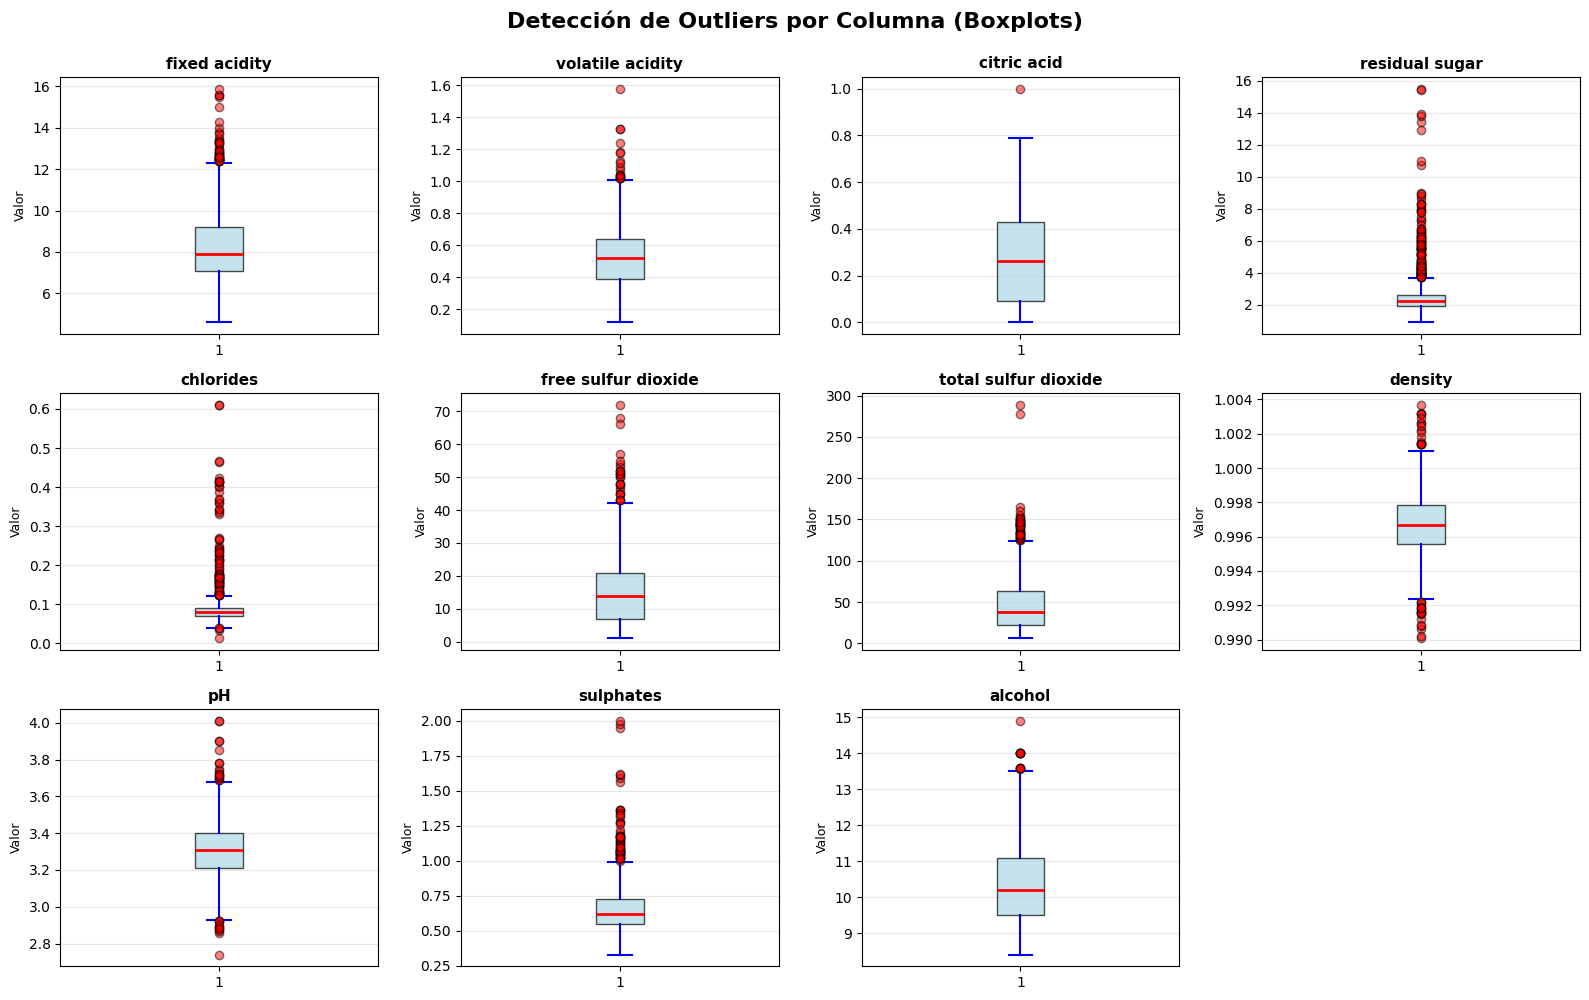

📌 Los puntos rojos fuera de los bigotes son outliers


In [8]:
# Visualización de outliers con boxplots
fig, axes = plt.subplots(3, 4, figsize=(16, 10))
fig.suptitle('Detección de Outliers por Columna (Boxplots)', fontsize=16, fontweight='bold', y=0.995)

axes = axes.ravel()

for idx, col in enumerate(columnas_numericas):
    axes[idx].boxplot(df[col], vert=True, patch_artist=True,
                     boxprops=dict(facecolor='lightblue', alpha=0.7),
                     medianprops=dict(color='red', linewidth=2),
                     whiskerprops=dict(color='blue', linewidth=1.5),
                     capprops=dict(color='blue', linewidth=1.5),
                     flierprops=dict(marker='o', markerfacecolor='red', markersize=6, alpha=0.5))
    
    axes[idx].set_title(col, fontsize=11, fontweight='bold')
    axes[idx].grid(axis='y', alpha=0.3)
    axes[idx].set_ylabel('Valor', fontsize=9)

# Ocultar ejes sobrantes si hay menos de 12 columnas
for idx in range(len(columnas_numericas), len(axes)):
    axes[idx].axis('off')

plt.tight_layout()
plt.show()

print("📌 Los puntos rojos fuera de los bigotes son outliers")

# 2.1 Split train test

In [9]:
X = df.drop('quality',axis=1)
y = df['quality']

In [10]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 2.2 Codificamos la variable objetivo

**¿Por qué recodificamos la variable objetivo?**

La variable `quality` originalmente tiene valores que van de 3 a 8 (en una escala de 0-10). Para simplificar el problema de clasificación y mejorar el rendimiento del modelo KNN, agrupamos estos valores en 3 categorías:

- **Calidad Baja (1)**: valores ≤ 4
- **Calidad Media (2)**: valores 5-6  
- **Calidad Alta (3)**: valores ≥ 7

**Beneficios de este enfoque:**
1. **Reduce la complejidad**: Menos clases = modelo más simple y robusto
2. **Balancea mejor las clases**: Evita clases con muy pocas muestras
3. **Mejora la interpretabilidad**: Categorías más claras y prácticas
4. **Aumenta la precisión**: KNN funciona mejor con menos clases bien diferenciadas

**¿Por qué usamos Mapeo Manual?**

- **Mapeo manual**: Es ideal para **agrupar clases ordinales** con significado jerárquico, reduciendo el número de categorías mientras preservamos el orden natural de calidad.

In [11]:
# Verificar los valores únicos actuales
print("📊 Distribución original de 'quality':")
print(y_train.value_counts().sort_index())

# Recodificar la variable objetivo de 1-6 a 1-3
# Asumiendo que quieres agrupar: 1-2 -> 1, 3-4 -> 2, 5-6 -> 3
def recodificar_quality(valor):
    if valor <= 4:
        return 1  # Calidad baja
    elif valor <= 6:
        return 2  # Calidad media
    else:
        return 3  # Calidad alta

y_train_encoded = y_train.map(recodificar_quality)
y_test_encoded = y_test.map(recodificar_quality)

print("\n📊 Distribución recodificada (1-3):")
print(y_train_encoded.value_counts().sort_index())
print(f"\n✅ Variable objetivo recodificada correctamente")

📊 Distribución original de 'quality':
quality
3      6
4     42
5    457
6    432
7    136
8     14
Name: count, dtype: int64

📊 Distribución recodificada (1-3):
quality
1     48
2    889
3    150
Name: count, dtype: int64

✅ Variable objetivo recodificada correctamente


# 2.3 Escalado

In [12]:
# k-NN con datos escalados usando RobustScaler (resistente a outliers)
sc_robust = RobustScaler().fit(X_train)
yhat_robust = KNeighborsClassifier(n_neighbors=3, algorithm='brute').fit(sc_robust.transform(X_train), y_train_encoded).predict(sc_robust.transform(X_test))

📊 ACCURACY SCORE
Accuracy: 0.8199 (81.99%)
Predicciones correctas: 223 de 272

📊 MATRIZ DE CONFUSIÓN
[[  0  15   0]
 [  3 208  12]
 [  1  18  15]]



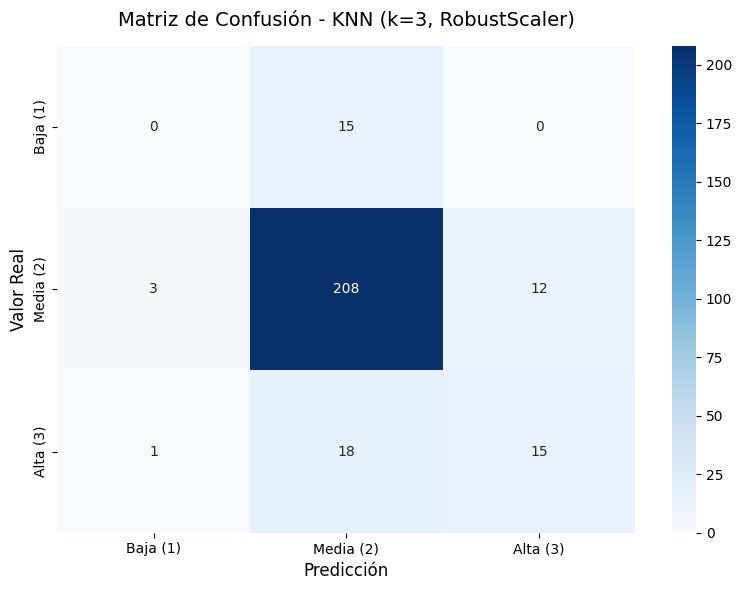


📊 CLASSIFICATION REPORT
               precision    recall  f1-score   support

 Calidad Baja       0.00      0.00      0.00        15
Calidad Media       0.86      0.93      0.90       223
 Calidad Alta       0.56      0.44      0.49        34

     accuracy                           0.82       272
    macro avg       0.47      0.46      0.46       272
 weighted avg       0.78      0.82      0.80       272




In [13]:


# 1. ACCURACY SCORE
accuracy = accuracy_score(y_test_encoded, yhat_robust)
print("=" * 50)
print("📊 ACCURACY SCORE")
print("=" * 50)
print(f"Accuracy: {accuracy:.4f} ({accuracy*100:.2f}%)")
print(f"Predicciones correctas: {int(accuracy * len(y_test_encoded))} de {len(y_test_encoded)}")
print()

# 2. CONFUSION MATRIX
print("=" * 50)
print("📊 MATRIZ DE CONFUSIÓN")
print("=" * 50)
cm = confusion_matrix(y_test_encoded, yhat_robust)
print(cm)
print()

# Visualizar matriz de confusión
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Baja (1)', 'Media (2)', 'Alta (3)'],
            yticklabels=['Baja (1)', 'Media (2)', 'Alta (3)'])
plt.title('Matriz de Confusión - KNN (k=3, RobustScaler)', fontsize=14, pad=15)
plt.ylabel('Valor Real', fontsize=12)
plt.xlabel('Predicción', fontsize=12)
plt.tight_layout()
plt.show()
print()

# 3. CLASSIFICATION REPORT
print("=" * 50)
print("📊 CLASSIFICATION REPORT")
print("=" * 50)
print(classification_report(y_test_encoded, yhat_robust, 
                          target_names=['Calidad Baja', 'Calidad Media', 'Calidad Alta']))
print()

# 3.2 Optimización de k

In [14]:
# Probar diferentes valores de k

# Rango de valores de k a probar
k_values = range(1, 21)
accuracy_scores = []
f1_scores = []
modelos_knn = {}  # Diccionario para almacenar cada modelo

# Datos escalados con RobustScaler
X_train_scaled = sc_robust.transform(X_train)
X_test_scaled = sc_robust.transform(X_test)

print("🔄 Probando diferentes valores de k...\n")

# Bucle para probar cada valor de k
for k in k_values:
    # Entrenar modelo con k vecinos
    knn = KNeighborsClassifier(n_neighbors=k, algorithm='brute')
    knn.fit(X_train_scaled, y_train_encoded)
    
    # Guardar el modelo en el diccionario
    modelos_knn[k] = knn
    
    # Predecir
    y_pred = knn.predict(X_test_scaled)
    
    # Calcular métricas
    acc = accuracy_score(y_test_encoded, y_pred)
    f1 = f1_score(y_test_encoded, y_pred, average='macro')
    
    accuracy_scores.append(acc)
    f1_scores.append(f1)

print("✅ Entrenamiento completado\n")
print("📊 Resultados por modelo:\n")

# Recorrer el diccionario de modelos y mostrar métricas
for idx, (k, modelo) in enumerate(modelos_knn.items()):
    print(f"Modelo KNN (k={k:2d}) → Accuracy: {accuracy_scores[idx]:.4f} | F1-Score: {f1_scores[idx]:.4f}")

print(f"\n📦 {len(modelos_knn)} modelos guardados en el diccionario 'modelos_knn'")

🔄 Probando diferentes valores de k...

✅ Entrenamiento completado

📊 Resultados por modelo:

Modelo KNN (k= 1) → Accuracy: 0.7757 | F1-Score: 0.4684
Modelo KNN (k= 2) → Accuracy: 0.7978 | F1-Score: 0.4641
Modelo KNN (k= 3) → Accuracy: 0.8199 | F1-Score: 0.4628
Modelo KNN (k= 4) → Accuracy: 0.8235 | F1-Score: 0.4476
Modelo KNN (k= 5) → Accuracy: 0.8162 | F1-Score: 0.4587
Modelo KNN (k= 6) → Accuracy: 0.8235 | F1-Score: 0.4541
Modelo KNN (k= 7) → Accuracy: 0.8456 | F1-Score: 0.4968
Modelo KNN (k= 8) → Accuracy: 0.8493 | F1-Score: 0.4863
Modelo KNN (k= 9) → Accuracy: 0.8529 | F1-Score: 0.5016
Modelo KNN (k=10) → Accuracy: 0.8493 | F1-Score: 0.4713
Modelo KNN (k=11) → Accuracy: 0.8382 | F1-Score: 0.4660
Modelo KNN (k=12) → Accuracy: 0.8529 | F1-Score: 0.4814
Modelo KNN (k=13) → Accuracy: 0.8419 | F1-Score: 0.4697
Modelo KNN (k=14) → Accuracy: 0.8529 | F1-Score: 0.4688
Modelo KNN (k=15) → Accuracy: 0.8493 | F1-Score: 0.4774
Modelo KNN (k=16) → Accuracy: 0.8493 | F1-Score: 0.4713
Modelo KNN 

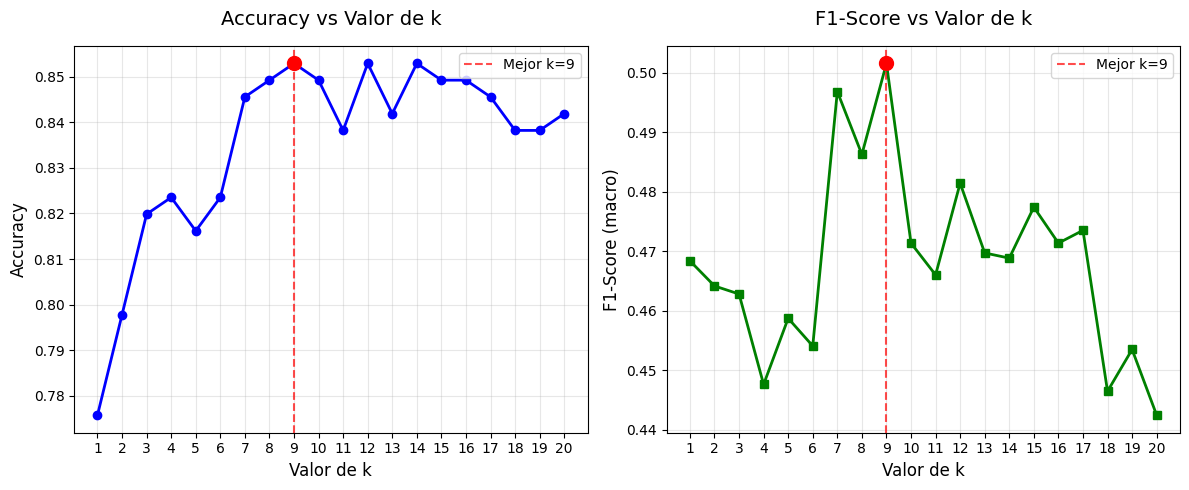

🏆 VALORES ÓPTIMOS DE K
Mejor k según Accuracy: 9 → 0.8529
Mejor k según F1-Score: 9 → 0.5016

💡 Recomendación: Usa el k con mejor F1-Score para clasificación balanceada


In [15]:
# Graficar Accuracy vs k
plt.figure(figsize=(12, 5))

# Subplot 1: Accuracy
plt.subplot(1, 2, 1)
plt.plot(k_values, accuracy_scores, marker='o', linestyle='-', linewidth=2, markersize=6, color='blue')
plt.xlabel('Valor de k', fontsize=12)
plt.ylabel('Accuracy', fontsize=12)
plt.title('Accuracy vs Valor de k', fontsize=14, pad=15)
plt.grid(True, alpha=0.3)
plt.xticks(k_values)

# Marcar el mejor k para accuracy
best_k_acc = k_values[np.argmax(accuracy_scores)]
best_acc = max(accuracy_scores)
plt.axvline(x=best_k_acc, color='red', linestyle='--', alpha=0.7, label=f'Mejor k={best_k_acc}')
plt.scatter([best_k_acc], [best_acc], color='red', s=100, zorder=5)
plt.legend()

# Subplot 2: F1-Score
plt.subplot(1, 2, 2)
plt.plot(k_values, f1_scores, marker='s', linestyle='-', linewidth=2, markersize=6, color='green')
plt.xlabel('Valor de k', fontsize=12)
plt.ylabel('F1-Score (macro)', fontsize=12)
plt.title('F1-Score vs Valor de k', fontsize=14, pad=15)
plt.grid(True, alpha=0.3)
plt.xticks(k_values)

# Marcar el mejor k para f1-score
best_k_f1 = k_values[np.argmax(f1_scores)]
best_f1 = max(f1_scores)
plt.axvline(x=best_k_f1, color='red', linestyle='--', alpha=0.7, label=f'Mejor k={best_k_f1}')
plt.scatter([best_k_f1], [best_f1], color='red', s=100, zorder=5)
plt.legend()

plt.tight_layout()
plt.show()

# Mostrar resultados óptimos
print("=" * 50)
print("🏆 VALORES ÓPTIMOS DE K")
print("=" * 50)
print(f"Mejor k según Accuracy: {best_k_acc} → {best_acc:.4f}")
print(f"Mejor k según F1-Score: {best_k_f1} → {best_f1:.4f}")
print("\n💡 Recomendación: Usa el k con mejor F1-Score para clasificación balanceada")

# 4. Guardar el mejor modelo

In [16]:
# Seleccionar el mejor modelo según F1-Score
best_k = best_k_f1
best_model = modelos_knn[best_k]

print("=" * 60)
print("💾 GUARDANDO EL MEJOR MODELO")
print("=" * 60)
print(f"Modelo seleccionado: KNN con k={best_k}")
print(f"F1-Score: {best_f1:.4f}")
print(f"Accuracy: {accuracy_scores[best_k-1]:.4f}")
print()

# Crear diccionario con toda la información del modelo
modelo_completo = {
    'modelo': best_model,
    'scaler': sc_robust,
    'k_optimo': best_k,
    'f1_score': best_f1,
    'accuracy': accuracy_scores[best_k-1],
    'features': X_train.columns.tolist(),
    'clases': ['Calidad Baja', 'Calidad Media', 'Calidad Alta']
}

# Guardar modelo con joblib
ruta_modelo = '/workspaces/carlos060495-intro-ml/models/knn_wine_quality_model.pkl'

joblib.dump(modelo_completo, ruta_modelo)

print(f"✅ Modelo guardado exitosamente en:")
print(f"   {ruta_modelo}")

💾 GUARDANDO EL MEJOR MODELO
Modelo seleccionado: KNN con k=9
F1-Score: 0.5016
Accuracy: 0.8529

✅ Modelo guardado exitosamente en:
   /workspaces/carlos060495-intro-ml/models/knn_wine_quality_model.pkl
